In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot
pyplot.ion()
pyplot.style.use('dark_background')

import torch as th
from torch import autograd as tha
from torch.utils import data


In [2]:
# Section 2: Warmup Behavior Cloning.

import math
import os
import pickle

import numpy as np

from rl.algs import plotter
from rl.algs.pg import Environment
from rl.algs.pg import PolicySnapshots

dtype = th.cuda.FloatTensor

os.chdir('/home/z/code/blaze_root/src/rl/berkeleyrlcourse/hw1')

class Model(th.nn.Module):
  def __init__(self, obs_dim, action_dim, model_std, min_std=None,
               hidden_dim=64, depth=6):
    super().__init__()
    self.min_logstd = math.log(min_std) if min_std else None
    modules = [
      th.nn.Linear(obs_dim, hidden_dim),
      th.nn.ReLU(),
    ]
    for _ in range(depth - 3):
      modules.append(th.nn.Linear(hidden_dim, hidden_dim))
      modules.append(th.nn.ReLU())
    self.base_nn = th.nn.Sequential(*modules)
    self.means = th.nn.Sequential(
      th.nn.Linear(hidden_dim, hidden_dim),
      th.nn.ReLU(),
      th.nn.Linear(hidden_dim, hidden_dim),
      th.nn.ReLU(),
      th.nn.Linear(hidden_dim, action_dim),
    )
    if model_std:
      self.logstds = th.nn.Sequential(
        th.nn.Linear(hidden_dim, hidden_dim),
        th.nn.ReLU(),
        th.nn.Linear(hidden_dim, hidden_dim),
        th.nn.ReLU(),
        th.nn.Linear(hidden_dim, action_dim)
      )
    else:
      self._logstds = th.nn.Parameter(th.zeros((1, action_dim)).type(dtype))
      self.logstds = lambda _: self._logstds

  def forward(self, x):
    x = self.base_nn(x)
    logstds = self.logstds(x)
    if self.min_logstd is not None:
      logstds = th.clamp(logstds, min=self.min_logstd)
    return self.means(x), logstds

class ImitationPolicy(object):
  """Continuous action policy, trained on imitation."""
  def __init__(self, expert_dataset, model, lr=0.001):
    self.model = model
    self.optimizer = th.optim.Adam(self.model.parameters(), lr)
 
  def get_action(self, obs_np):
    obs_var = tha.Variable(th.from_numpy(obs_np).type(dtype))
    dist = self._get_action_distribution(obs_var)
    ac = dist.sample()
    out_np = ac.data.cpu().numpy()
    return out_np
  
  def _get_action_distribution(self, obs_var):
    means, logstds = self.model(obs_var)
    stds = th.exp(logstds)
    dist = th.distributions.Normal(means, stds)
    return dist

  def step(self, obs_batch, acs_batch):
    metrics = {}
    obs_var = tha.Variable(obs_batch.type(dtype))
    acs_var = tha.Variable(acs_batch.type(dtype))
    dist = self._get_action_distribution(obs_var)
    log_probs = dist.log_prob(acs_var)
    loss = -log_probs.mean()
    
    metrics['loss'] = loss.data.cpu().numpy()[0]
    metrics['ac_mean'] = dist.mean.data.cpu().numpy()
    metrics['ac_std'] = dist.std.data.cpu().numpy()
    
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
 
    return metrics

class ExpertDataset(object):
  def __init__(self, pkl_file, batch_size):
    with open(pkl_file, 'rb') as fd:
      rollouts = pickle.load(fd)
    self.obs = rollouts['observations']
    self.acs = rollouts['actions']
    
    print(f'From {pkl_file}')
    print(f'Loaded observations: {self.obs.shape}')
    print(f'Loaded actions: {self.acs.shape}')
    
    obs_tensor = th.from_numpy(self.obs).cuda()
    acs_tensor = th.from_numpy(self.acs).cuda()
    
    dataset = data.TensorDataset(obs_tensor, acs_tensor)
    self.data_loader = data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True)
    
  @property
  def obs_dim(self):
    return self.obs.shape[-1]
  
  @property
  def acs_dim(self):
    return self.acs.shape[-1]
    
  def __iter__(self):
    self.iter = iter(self.data_loader)
    return self
  
  def __next__(self):
    try:
      return next(self.iter)
    except StopIteration:
      self.iter = iter(self.data_loader)
      return next(self.iter)



In [ ]:
# Hopper-v1
NUM_STEPS = 50001
MINI_BATCH_SIZE = 1000
STEPS_PER_POLICY_EVAL = 1000
EPS_PER_POLICY_EVAL = 5
plt = plotter.Plotter()

ENV_NAME = 'Hopper-v1'
#ENV_NAME = 'Humanoid-v1'
env = Environment(env_name=ENV_NAME)

pkl_file = f'expert_rollouts/{ENV_NAME}/n100_1.pkl'
expert_ds = ExpertDataset(pkl_file, batch_size=MINI_BATCH_SIZE)
model = Model(expert_ds.obs_dim, expert_ds.acs_dim,
              model_std=True,
              min_std=None, #0.01,
              hidden_dim=256,
              depth=8).cuda()
policy = ImitationPolicy(expert_ds, model, lr=0.001)
snapshots = PolicySnapshots()

for i, (obs_batch, acs_batch) in zip(range(NUM_STEPS), expert_ds):
  metrics = policy.step(obs_batch, acs_batch)
  for name, values in metrics.items():
    plt.add_data(name, i, values)

  if i % STEPS_PER_POLICY_EVAL == 0:
    snapshots.snapshot(i, policy)
    eps = env.sample_rollouts(policy.get_action, num_episodes=EPS_PER_POLICY_EVAL)
    r_per_eps = [sum([sar.r for sar in ep]) for ep in eps]
    plt.add_data('r_per_eps', i, r_per_eps)
    print(f'Step: {i}; Loss: {metrics["loss"]}; R: {np.mean(r_per_eps)}')


plt.line_plot()
plt.render()


In [5]:
# Show an episode of the imitation policy
try:
  env = Environment(env_name=ENV_NAME)
  eps = env.sample_rollouts(snapshots.get(3000).get_action, num_episodes=3, render=True)
  r_per_eps = [sum([sar.r for sar in ep]) for ep in eps]
  print(r_per_eps)
finally:
  env.env.render(close=True)


[2018-01-27 01:15:14,288] Making new env: HalfCheetah-v1


[3944.9070434721016, 4209.247082221253, 4167.73762695899]


[2018-01-27 01:00:09,643] Making new env: Ant-v1


From expert_rollouts/Ant-v1/n100_1.pkl
Loaded observations: (99265, 111)
Loaded actions: (99265, 8)


Step: 0; Loss: 0.9674668908119202; R: -201.997026345808


Step: 500; Loss: -1.1512360572814941; R: 1483.1626568034576


Step: 1000; Loss: -1.723113775253296; R: 2362.7712476616007


Step: 1500; Loss: -1.983526349067688; R: 3986.0608734264342


Step: 2000; Loss: -2.138946056365967; R: 4518.500163487569


Step: 2500; Loss: -2.1623353958129883; R: 4624.37801743644


Step: 3000; Loss: -2.4784038066864014; R: 4655.4239505082205


Step: 3500; Loss: -2.6056156158447266; R: 4817.734807326723


Step: 4000; Loss: -2.2854115962982178; R: 4503.669584128406


Step: 4500; Loss: -2.492997407913208; R: 4677.661661726748


Step: 5000; Loss: -2.1689069271087646; R: 4633.681068217899


Step: 5500; Loss: -2.633120059967041; R: 4735.618712217894


Step: 6000; Loss: -2.9217097759246826; R: 4820.778252481944


Step: 6500; Loss: -1.6663881540298462; R: 4439.148297465587


Step: 7000; Loss: -2.997981309890747; R: 4842.7305820602505


Step: 7500; Loss: -3.021033763885498; R: 4772.953448295868


Step: 8000; Loss: -2.6633553504943848; R: 4780.316415708019


Step: 8500; Loss: -2.8984436988830566; R: 4771.50272070467


Step: 9000; Loss: -1.6880438327789307; R: 4358.686121958668


Step: 9500; Loss: -2.6357738971710205; R: 4764.632014004931


Step: 10000; Loss: -1.9861557483673096; R: 4674.864492288624


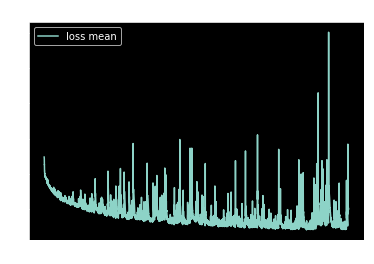

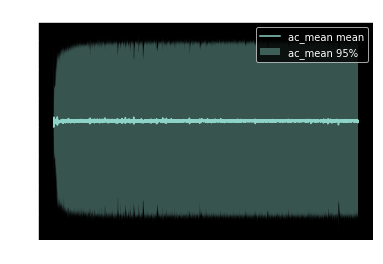

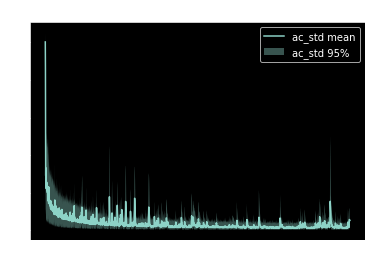

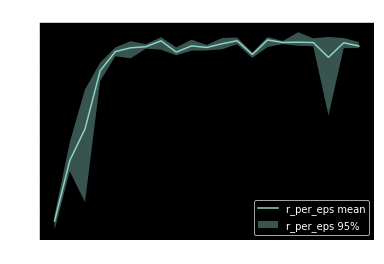

In [3]:
# Ant-v1
NUM_STEPS = 5001
MINI_BATCH_SIZE = 500
STEPS_PER_POLICY_EVAL = 500
EPS_PER_POLICY_EVAL = 5
plt = plotter.Plotter()

ENV_NAME = 'Ant-v1'
env = Environment(env_name=ENV_NAME)

pkl_file = f'expert_rollouts/{ENV_NAME}/n100_1.pkl'
expert_ds = ExpertDataset(pkl_file, batch_size=MINI_BATCH_SIZE)
model = Model(expert_ds.obs_dim, expert_ds.acs_dim,
              model_std=True,
              min_std=None, #0.01,
              hidden_dim=256,
              depth=8).cuda()
policy = ImitationPolicy(expert_ds, model, lr=0.001)
snapshots = PolicySnapshots()

for i, (obs_batch, acs_batch) in zip(range(NUM_STEPS), expert_ds):
  metrics = policy.step(obs_batch, acs_batch)
  for name, values in metrics.items():
    plt.add_data(name, i, values)

  if i % STEPS_PER_POLICY_EVAL == 0:
    snapshots.snapshot(i, policy)
    eps = env.sample_rollouts(policy.get_action, num_episodes=EPS_PER_POLICY_EVAL)
    r_per_eps = [sum([sar.r for sar in ep]) for ep in eps]
    plt.add_data('r_per_eps', i, r_per_eps)
    print(f'Step: {i}; Loss: {metrics["loss"]}; R: {np.mean(r_per_eps)}')


plt.line_plot()
plt.render()



[2018-01-27 01:13:18,392] Making new env: HalfCheetah-v1


From expert_rollouts/HalfCheetah-v1/n100_1.pkl
Loaded observations: (100000, 17)
Loaded actions: (100000, 6)


Step: 0; Loss: 1.211681604385376; R: -502.107756071091


Step: 1000; Loss: -1.423622727394104; R: 3818.869699095737


Step: 2000; Loss: -1.783407211303711; R: 4033.3259576260543


Step: 3000; Loss: -2.035823345184326; R: 4011.832022827959


Step: 4000; Loss: -1.64619779586792; R: 4011.4720708855248


Step: 5000; Loss: -1.2865220308303833; R: 3730.522147055211


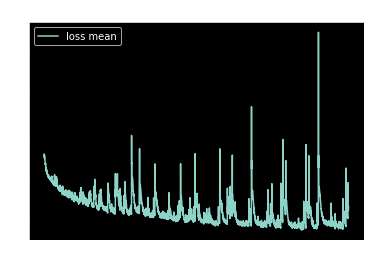

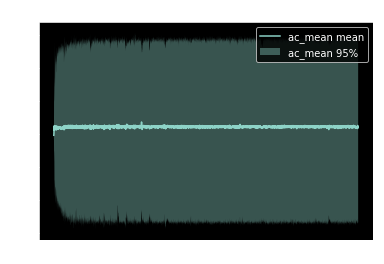

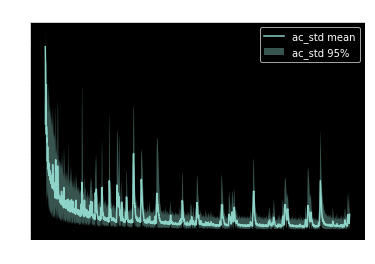

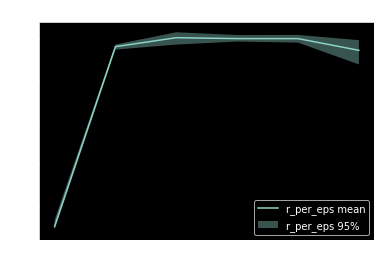

In [4]:
# HalfCheetah-v1
NUM_STEPS = 5001
MINI_BATCH_SIZE = 500
STEPS_PER_POLICY_EVAL = 1000
EPS_PER_POLICY_EVAL = 5
plt = plotter.Plotter()

ENV_NAME = 'HalfCheetah-v1'
env = Environment(env_name=ENV_NAME)

pkl_file = f'expert_rollouts/{ENV_NAME}/n100_1.pkl'
expert_ds = ExpertDataset(pkl_file, batch_size=MINI_BATCH_SIZE)
model = Model(expert_ds.obs_dim, expert_ds.acs_dim,
              model_std=True,
              min_std=None, #0.01,
              hidden_dim=256,
              depth=8).cuda()
policy = ImitationPolicy(expert_ds, model, lr=0.001)
snapshots = PolicySnapshots()

for i, (obs_batch, acs_batch) in zip(range(NUM_STEPS), expert_ds):
  metrics = policy.step(obs_batch, acs_batch)
  for name, values in metrics.items():
    plt.add_data(name, i, values)

  if i % STEPS_PER_POLICY_EVAL == 0:
    snapshots.snapshot(i, policy)
    eps = env.sample_rollouts(policy.get_action, num_episodes=EPS_PER_POLICY_EVAL)
    r_per_eps = [sum([sar.r for sar in ep]) for ep in eps]
    plt.add_data('r_per_eps', i, r_per_eps)
    print(f'Step: {i}; Loss: {metrics["loss"]}; R: {np.mean(r_per_eps)}')


plt.line_plot()
plt.render()


In [7]:
# Humanoid-v1
NUM_STEPS = 10001
MINI_BATCH_SIZE = 500
STEPS_PER_POLICY_EVAL = 1000
EPS_PER_POLICY_EVAL = 5
plt = plotter.Plotter()

ENV_NAME = 'Humanoid-v1'
env = Environment(env_name=ENV_NAME)

pkl_file = f'expert_rollouts/{ENV_NAME}/n100_1.pkl'
expert_ds = ExpertDataset(pkl_file, batch_size=MINI_BATCH_SIZE)
model = Model(expert_ds.obs_dim, expert_ds.acs_dim,
              model_std=True,
              min_std=None, #0.01,
              hidden_dim=512,
              depth=8).cuda()
policy = ImitationPolicy(expert_ds, model, lr=0.005)
snapshots = PolicySnapshots()

for i, (obs_batch, acs_batch) in zip(range(NUM_STEPS), expert_ds):
  metrics = policy.step(obs_batch, acs_batch)
  for name, values in metrics.items():
    plt.add_data(name, i, values)

  if i % STEPS_PER_POLICY_EVAL == 0:
    snapshots.snapshot(i, policy)
    eps = env.sample_rollouts(policy.get_action, num_episodes=EPS_PER_POLICY_EVAL)
    r_per_eps = [sum([sar.r for sar in ep]) for ep in eps]
    plt.add_data('r_per_eps', i, r_per_eps)
    print(f'Step: {i}; Loss: {metrics["loss"]}; R: {np.mean(r_per_eps)}')


plt.line_plot()
plt.render()


[2018-01-27 01:22:52,822] Making new env: Humanoid-v1


From expert_rollouts/Humanoid-v1/n100_1.pkl
Loaded observations: (100000, 376)
Loaded actions: (100000, 17)


Step: 0; Loss: 1.5339480638504028; R: 85.71480730894885


Step: 1000; Loss: nan; R: 5000.24233655066


Step: 2000; Loss: nan; R: 4999.716983421635


Step: 3000; Loss: nan; R: 4999.575493302746


Step: 4000; Loss: nan; R: 4999.964492227602
